In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(style="darkgrid")

import time
import os
import psutil
import pickle

## Preaprea Data

In [2]:
# Read data file
data_file = './CleanAdult.csv'
data_df = pd.read_csv(data_file)

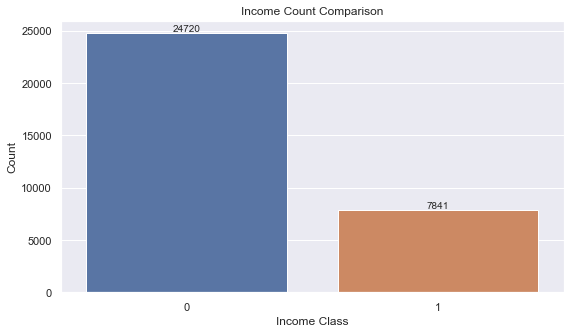

In [3]:
# Plot label
plt.figure(figsize=(9, 5))
plt.title('Income Count Comparison')
ax1 = sns.countplot(data=data_df, x='income', label='Count')
for container in ax1.containers:
    ax1.bar_label(container)

plt.xlabel('Income Class')
plt.ylabel('Count')
plt.show()

In [7]:
# Check quarter of age
age_q1 = data_df['age'].quantile(0.25)
age_q2 = data_df['age'].quantile(0.50)
age_q3 = data_df['age'].quantile(0.75)
age_q4 = data_df['age'].quantile(1.00)
age_iqr = age_q3 - age_q1


print(f'Quartile 1 Age: {age_q1}')
print(f'Quartile 2 Age: {age_q2}')
print(f'Quartile 3 Age: {age_q3}')
print(f'Quartile 4 Age: {age_q4}')

Quartile 1 Age: 28.0
Quartile 2 Age: 37.0
Quartile 3 Age: 48.0
Quartile 4 Age: 90.0


In [8]:
lower_bound = age_q1 - 1.0 * age_iqr
upper_bound = age_q3 + 1.0 * age_iqr
# Remove outliers
data_df_v2 = data_df[(data_df['age'] >= lower_bound) & (data_df['age'] <= upper_bound)]

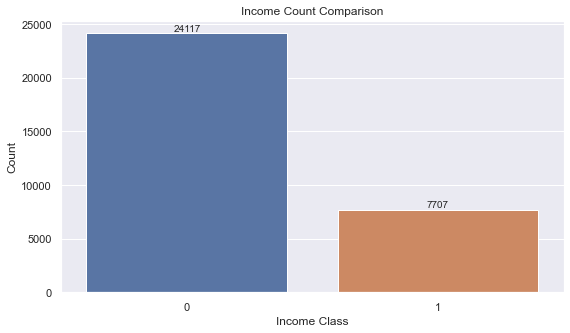

In [9]:
# Plot label
plt.figure(figsize=(9, 5))
plt.title('Income Count Comparison')
ax1 = sns.countplot(data=data_df_v2, x='income', label='Count')
for container in ax1.containers:
    ax1.bar_label(container)

plt.xlabel('Income Class')
plt.ylabel('Count')
plt.show()

## Fairness Model Part

In [10]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score ,accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [11]:
class_names = ['<=50k', '>50k']

In [12]:
# Encode category data
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
categorical_data = data_df[categorical_columns]

encoder = OrdinalEncoder()
encoded_categorical_data = encoder.fit_transform(categorical_data)

# Replace the original categorical columns with the encoded values
data_df[categorical_columns] = encoded_categorical_data

In [13]:
X = data_df_v2.drop(columns= ['income', 'fnlwgt', 'education'])
Y = data_df_v2['income']

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=13)

In [14]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

from aif360.sklearn.metrics import equal_opportunity_difference, average_odds_difference

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [15]:
x_test

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
6118,46,3.0,9,0.0,2.0,2.0,4.0,1.0,0,0,40,38.0
28366,38,3.0,13,2.0,2.0,0.0,4.0,1.0,0,0,45,38.0
18276,25,1.0,13,4.0,0.0,2.0,2.0,0.0,0,0,40,38.0
14502,40,3.0,9,0.0,0.0,4.0,4.0,0.0,0,0,50,38.0
22595,23,3.0,3,4.0,5.0,1.0,4.0,1.0,0,0,55,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5332,37,3.0,10,2.0,0.0,0.0,4.0,1.0,0,0,37,38.0
17168,28,3.0,13,4.0,5.0,2.0,4.0,1.0,0,0,25,38.0
10511,27,3.0,10,4.0,0.0,3.0,4.0,1.0,0,0,20,38.0
21982,55,0.0,14,2.0,3.0,0.0,4.0,1.0,0,0,60,38.0


## Reweighing Data

In [16]:
# Set protected feature
privileged_groups = [{'sex': 1}]  
unprivileged_groups = [{'sex': 0}]

# Concat label back for right format input
tmp_train = pd.concat([x_train, y_train.set_axis(x_train.index)], axis=1)
tmp_test = pd.concat([x_test, y_test.set_axis(x_test.index)], axis=1)

# Make dataset
training_data_format = BinaryLabelDataset(df= tmp_train, label_names=['income'], 
                             protected_attribute_names=['sex'])

In [17]:
# Metric without apply method
nonreweight_mat = BinaryLabelDatasetMetric(training_data_format, 
                                           unprivileged_groups= unprivileged_groups,
                                           privileged_groups= privileged_groups)

# Check base dataset score
print(f'Original Train Data with difference in mean outcomes between unprivileged and privileged groups: {nonreweight_mat.mean_difference():.4f}')
print(f'Original Train Data Disparate Impact: {nonreweight_mat.disparate_impact():.4f}')

Original Train Data with difference in mean outcomes between unprivileged and privileged groups: -0.2005
Original Train Data Disparate Impact: 0.3531


In [18]:
# Pre-processing: Reweighing method
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
rewighted_train_data = RW.fit_transform(training_data_format)

# Check score
reweight_mat = BinaryLabelDatasetMetric(rewighted_train_data, 
                                        unprivileged_groups= unprivileged_groups,
                                        privileged_groups= privileged_groups)

# Check base dataset score
print(f'Transformed Train Data with difference in mean outcomes between unprivileged and privileged groups: {reweight_mat.mean_difference():.4f}')
print(f'Transformed Train Data Disparate Impact: {reweight_mat.disparate_impact():.4f}')

Transformed Train Data with difference in mean outcomes between unprivileged and privileged groups: 0.0000
Transformed Train Data Disparate Impact: 1.0000


In [20]:
def train_reweight(input_model, model_name, data_file, x_test, y_test):
    X_train_reweighted = pd.DataFrame(data_file.features, columns=data_file.feature_names)
    y_train_reweighted = data_file.labels.ravel()
    # Train
    trained_model = input_model.fit(X_train_reweighted, y_train_reweighted)
    y_pred = trained_model.predict(x_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')
    eod = equal_opportunity_difference(y_test, y_pred)
    aod = average_odds_difference(y_test, y_pred)
    # Confusion natric
    mat = confusion_matrix(y_test, y_pred)
    TN = mat[0][0]
    FN = mat[1][0]
    TP = mat[1][1]
    FP = mat[0][1]
    print(f'Accuracy: {accuracy*100:.4f}')
    print(f'Recall: {recall*100:.4f}')
    print(f'Precision: {precision*100:.4f}')
    print(f'F1-Score: {f1*100:.4f}')
    print(f'EoD: {eod:.4f}')
    print(f'AoD: {aod:.4f}')
    print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')
    fig , ax = plot_confusion_matrix(conf_mat= mat, figsize=(8, 8),
                                     cmap= plt.cm.Blues,
                                     class_names= class_names,
                                     colorbar= True)
    disp = plt.title(f'Confusion Matrix of {model_name} Rewight Prediction')
    plt.show()
    return trained_model

## RF Rewight Model

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 85.3687
Recall: 85.3687
Precision: 84.8333
F1-Score: 84.9813
EoD: 0.6247
AoD: -0.1504
TP: 1425, FP: 541, TN: 6726, FN: 856


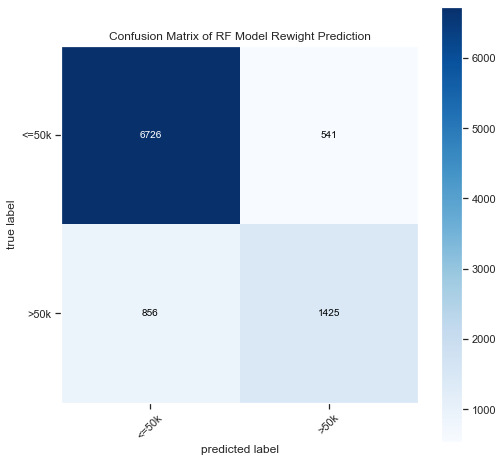

In [17]:
# Build model
rf_base = RandomForestClassifier(n_estimators=300)
reweight_rf_model = train_reweight(rf_base, 'RF Model', rewighted_train_data, x_test, y_test)

## LightGBM Model

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 87.1806
Recall: 87.1806
Precision: 86.7286
F1-Score: 86.7962
EoD: 0.6545
AoD: -0.1427
TP: 1493, FP: 436, TN: 6831, FN: 788


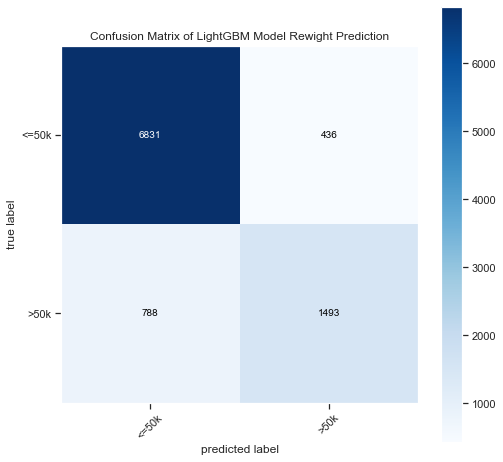

In [21]:
# Build model
lightGBM_base = LGBMClassifier(n_estimators=300, verbose=-1)
reweight_lgbm_model = train_reweight(lightGBM_base, 'LightGBM Model', rewighted_train_data, x_test, y_test)

## SVM Model

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 80.1948
Recall: 80.1948
Precision: 79.0319
F1-Score: 76.5241
EoD: 0.2701
AoD: -0.3494
TP: 616, FP: 226, TN: 7041, FN: 1665


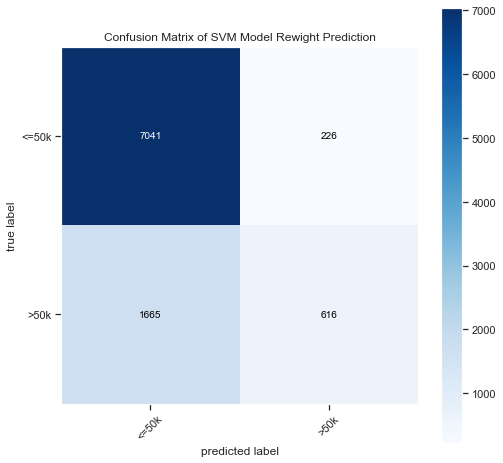

In [19]:
svm_base = SVC()
reweight_svm_model = train_reweight(svm_base, 'SVM Model', rewighted_train_data, x_test, y_test)

## MLP Model

Accuracy: 83.0017
Recall: 83.0017
Precision: 82.2199
F1-Score: 81.0201
EoD: 0.4130
AoD: -0.2740
TP: 942, FP: 284, TN: 6983, FN: 1339


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


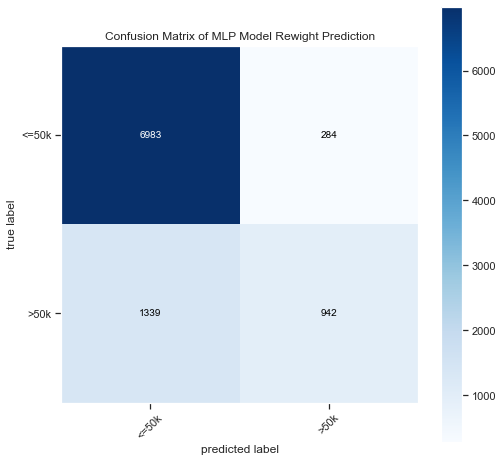

In [20]:
# Build MLP model
mlp_base = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=400)
reweight_mlp_model = train_reweight(mlp_base, 'MLP Model', rewighted_train_data, x_test, y_test)

## LR Model

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 80.9384
Recall: 80.9384
Precision: 79.3777
F1-Score: 78.8361
EoD: 0.3788
AoD: -0.2829
TP: 864, FP: 403, TN: 6864, FN: 1417


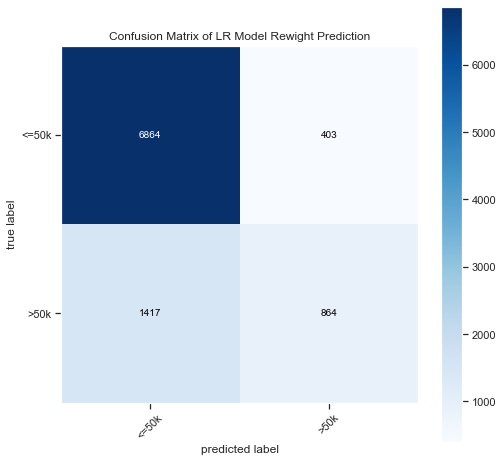

In [21]:
# Build model
lr_base = LogisticRegression()
reweight_lr_model = train_reweight(lr_base, 'LR Model', rewighted_train_data, x_test, y_test)

## K-NN Model

Accuracy: 84.6669
Recall: 84.6669
Precision: 84.1156
F1-Score: 84.2880
EoD: 0.6142
AoD: -0.1527
TP: 1401, FP: 584, TN: 6683, FN: 880


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


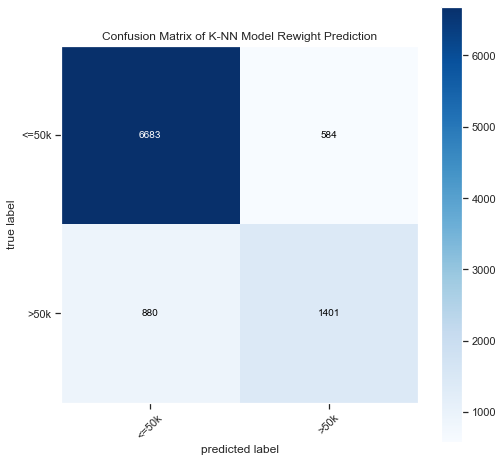

In [22]:
# Build
knn_base = KNeighborsClassifier(n_neighbors = 7)
reweight_knn_model = train_reweight(knn_base, 'K-NN Model', rewighted_train_data, x_test, y_test)

## Load RMO Baseline

In [23]:
import joblib

In [24]:
def old_predict(model, model_name, x_test, y_test):
    # Predict
    y_pred = model.predict(x_test)
    
    # Find fairness metric
    eod = equal_opportunity_difference(y_test, y_pred)
    aod = average_odds_difference(y_test, y_pred)
    print(f'{model_name} EoD: {eod:.4f}')
    print(f'{model_name} AoD: {aod:.4f}')

## Old RF

In [25]:
# Load model
rf_file = r'C:\Users\ASUS\Desktop\Learning\masterDegree\thirdSemester\sdForDataScience\project\Milestone2\Milestone2_materials\model\rmo_rf.pkl'
rf_loaded_model = joblib.load(rf_file)

# Find fairness mat
old_predict(rf_loaded_model, 'EMO RF Model', x_test, y_test)


EMO RF Model EoD: 0.3157
EMO RF Model AoD: -0.3042


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [26]:
# Load model
lgbm_file = r'C:\Users\ASUS\Desktop\Learning\masterDegree\thirdSemester\sdForDataScience\project\Milestone2\Milestone2_materials\model\rmo_lgbm.pkl'
lgbm_loaded_model = joblib.load(lgbm_file)

# Find fairness mat
old_predict(lgbm_loaded_model, 'EMO LGBM Model', x_test, y_test)


EMO LGBM Model EoD: 0.2082
EMO LGBM Model AoD: -0.3750


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [27]:
# Load model
svm_file = r'C:\Users\ASUS\Desktop\Learning\masterDegree\thirdSemester\sdForDataScience\project\Milestone2\Milestone2_materials\model\rmo_svm.pkl'
svm_loaded_model = joblib.load(svm_file)

# Find fairness mat
old_predict(svm_loaded_model, 'EMO SVM Model', x_test, y_test)


EMO SVM Model EoD: 0.0000
EMO SVM Model AoD: -0.5000


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [28]:
# Load model
mlp_file = r'C:\Users\ASUS\Desktop\Learning\masterDegree\thirdSemester\sdForDataScience\project\Milestone2\Milestone2_materials\model\rmo_mlp.pkl'
mlp_loaded_model = joblib.load(mlp_file)

# Find fairness mat
old_predict(mlp_loaded_model, 'EMO MLP Model', x_test, y_test)


EMO MLP Model EoD: 0.9706
EMO MLP Model AoD: 0.4645


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [29]:
# Load model
lr_file = r'C:\Users\ASUS\Desktop\Learning\masterDegree\thirdSemester\sdForDataScience\project\Milestone2\Milestone2_materials\model\rmo_lr.pkl'
lr_loaded_model = joblib.load(lr_file)

# Find fairness mat
old_predict(lr_loaded_model, 'EMO LR Model', x_test, y_test)


EMO LR Model EoD: 1.0000
EMO LR Model AoD: 0.5000


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [30]:
# Load model
knn_file = r'C:\Users\ASUS\Desktop\Learning\masterDegree\thirdSemester\sdForDataScience\project\Milestone2\Milestone2_materials\model\rmo_knn.pkl'
knn_loaded_model = joblib.load(knn_file)

# Find fairness mat
old_predict(knn_loaded_model, 'EMO K-NN Model', x_test, y_test)


EMO K-NN Model EoD: 0.2096
EMO K-NN Model AoD: -0.3733


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [22]:
reweight_lgbm_model

LGBMClassifier(n_estimators=300, verbose=-1)

In [23]:
import optuna

In [120]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 100, 500),
        "verbose": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 30),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
    }
    X_train_reweighted = pd.DataFrame(rewighted_train_data.features, columns=rewighted_train_data.feature_names)
    y_train_reweighted = rewighted_train_data.labels.ravel()
    # Train
    model = LGBMClassifier(**params)
    model.fit(X_train_reweighted, y_train_reweighted)
    predictions = model.predict(x_test)
    f1 = f1_score(y_test, predictions, average='weighted')
    #precision = precision_score(y_test, predictions, average='weighted')
    return f1

In [121]:
study = optuna.create_study(directions=['maximize'])
study.optimize(objective, n_trials=30)

[I 2023-10-30 18:50:36,772] A new study created in memory with name: no-name-89b97232-b18c-44d0-9ba0-26ca7417029b
[I 2023-10-30 18:50:37,280] Trial 0 finished with value: 0.8705203434873319 and parameters: {'n_estimators': 265, 'learning_rate': 0.07519425176384617, 'num_leaves': 26, 'subsample': 0.6220147839527873, 'colsample_bytree': 0.4636272443368752, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.8705203434873319.
[I 2023-10-30 18:50:37,649] Trial 1 finished with value: 0.7908074423340097 and parameters: {'n_estimators': 369, 'learning_rate': 0.0038074033344864186, 'num_leaves': 7, 'subsample': 0.06447044868721126, 'colsample_bytree': 0.3263635806836071, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.8705203434873319.
[I 2023-10-30 18:50:38,220] Trial 2 finished with value: 0.8675086804118937 and parameters: {'n_estimators': 332, 'learning_rate': 0.031199121079479294, 'num_leaves': 21, 'subsample': 0.2627758524612298, 'colsample_bytree': 0.9463052919733351, 'min_data

[I 2023-10-30 18:50:52,725] Trial 26 finished with value: 0.8647355318455237 and parameters: {'n_estimators': 347, 'learning_rate': 0.0971233089748674, 'num_leaves': 28, 'subsample': 0.2644209616564227, 'colsample_bytree': 0.7397473567786388, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.8714455178431344.
[I 2023-10-30 18:50:53,039] Trial 27 finished with value: 0.8658011830536669 and parameters: {'n_estimators': 145, 'learning_rate': 0.04060321515403683, 'num_leaves': 20, 'subsample': 0.5697225345791387, 'colsample_bytree': 0.6270658047071161, 'min_data_in_leaf': 9}. Best is trial 13 with value: 0.8714455178431344.
[I 2023-10-30 18:50:53,935] Trial 28 finished with value: 0.8668979545759296 and parameters: {'n_estimators': 384, 'learning_rate': 0.023052598248104423, 'num_leaves': 28, 'subsample': 0.48956488080821803, 'colsample_bytree': 0.7722939451296615, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.8714455178431344.
[I 2023-10-30 18:50:54,515] Trial 29 finished 

In [122]:
print('Best hyperparameters:', study.best_params)
#print('Best hyperparameters:', study.best_trials)
print(f'Best F1: {study.best_value:.4f}')

Best hyperparameters: {'n_estimators': 400, 'learning_rate': 0.04491534617054104, 'num_leaves': 25, 'subsample': 0.49650862911498106, 'colsample_bytree': 0.6927552301478413, 'min_data_in_leaf': 10}
Best F1: 0.8714


In [123]:
X_train_reweighted = pd.DataFrame(rewighted_train_data.features, columns=rewighted_train_data.feature_names)
y_train_reweighted = rewighted_train_data.labels.ravel()

tuned_lgmb_base = LGBMClassifier(**study.best_params, force_col_wise=True)
tuned_model = tuned_lgmb_base.fit(X_train_reweighted, y_train_reweighted)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 5426, number of negative: 16850
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 22276, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.243581 -> initscore=-1.133148
[LightGBM] [Info] Start training from score -1.133148


In [124]:
tuned_model

LGBMClassifier(colsample_bytree=0.6927552301478413, force_col_wise=True,
               learning_rate=0.04491534617054104, min_data_in_leaf=10,
               n_estimators=400, num_leaves=25, subsample=0.49650862911498106)

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
Accuracy: 87.5157
Recall: 87.5157
Precision: 87.0632
F1-Score: 87.0455
EoD: 0.6445
AoD: -0.1516


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Specificity is ill-defined and being set to 0.0 due to no negative samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


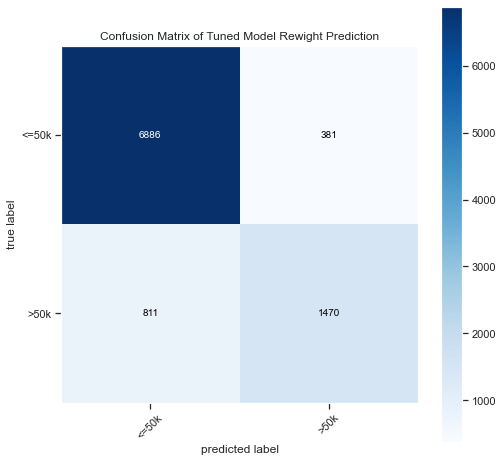

In [119]:
y_pred = tuned_model.predict(x_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted')
eod = equal_opportunity_difference(y_test, y_pred)
aod = average_odds_difference(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.4f}')
print(f'Recall: {recall*100:.4f}')
print(f'Precision: {precision*100:.4f}')
print(f'F1-Score: {f1*100:.4f}')
print(f'EoD: {eod:.4f}')
print(f'AoD: {aod:.4f}')
mat = confusion_matrix(y_test, y_pred)
fig , ax = plot_confusion_matrix(conf_mat= mat, figsize=(8, 8),
                                     cmap= plt.cm.Blues,
                                     class_names= class_names,
                                     colorbar= True)
disp = plt.title(f'Confusion Matrix of Tuned Model Rewight Prediction')
plt.show()